<h1>ALA 470 Final Project</h1>

<p>By Haley Johnson</p>

In [2]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

<h2>Load Data</h2>

In [3]:
df = pd.read_csv("fake.csv")
df_2 = pd.read_csv("news_articles.csv")

In [4]:
with open('stopwords.txt') as s:
    stopwords = s.read()

In [5]:
stopwords = stopwords.split(" ")

<h2>Clean Up</h2>

In [6]:
# UNCOMMENT IF YOU WANT TO USE BOTH FILES
# df_1['title'] = df_1['title'].str.lower()
# df_1['author'] = df_1['author'].str.lower()

# df_1 = df_1.drop(columns = {'language', 'site_url', 'main_img_url', 'type', 'published', 'text'}, axis = 1)

# df_2['title'] = df_2['title'].str.lower()
# df_2['author'] = df_2['author'].str.lower()

# df = df_1.merge(df_2, on = ['title', 'author'])

<h2>NLTK</h2>

<h3>Tokenize</h3>

In [7]:
df['text'] = df['text'].astype(str)
df['text_normalized'] = df['text'].str.lower()
df['tokens'] = df['text_normalized'].apply(lambda t: [word for sent in nltk.sent_tokenize(t) for word in nltk.word_tokenize(sent)])

In [8]:
df['title'] = df['title'].astype(str)
df['title_normalized'] = df['title'].str.lower()
df['title_tokens'] = df['title_normalized'].apply(nltk.word_tokenize)

In [9]:
df['non_stopwords'] = df['tokens'].apply(lambda x: [w for w in x if w not in stopwords])
df['non_stopwords_count'] = df['non_stopwords'].apply(len)

In [10]:
df['title_no_stopwords'] = df['title_tokens'].apply(lambda t: [w for w in t if w not in stopwords])

<h3>Top Tokens by Type</h3>

In [11]:
types = list(df['type'].unique())

In [12]:
top_tokens = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded_tokens = matches.explode('non_stopwords')
    exploded_tokens = exploded_tokens[pd.isnull(exploded_tokens['non_stopwords']) == False]
    top_tokens.append(exploded_tokens['non_stopwords'].value_counts())

<h3>Filter Out Puncutation Tokens</h3>

In [13]:
punctuation = ["'", "'", '"', '"', ".", "?", ",", "!", "-", ",", ".", '”', '“', ";", ":", "(", ")", "’",
               '–', "&", '``', "''", "'s", "...", ":", "@", "‘"]

In [14]:
for i in range(len(top_tokens)):
    current = top_tokens[i].reset_index().rename(columns = {'index': 'token', 'non_stopwords': 'count'} )
    current = current[current['token'].apply(lambda s: s not in punctuation) == True]
    top_tokens[i] = current

<h2>Visualize Tokens</h2>

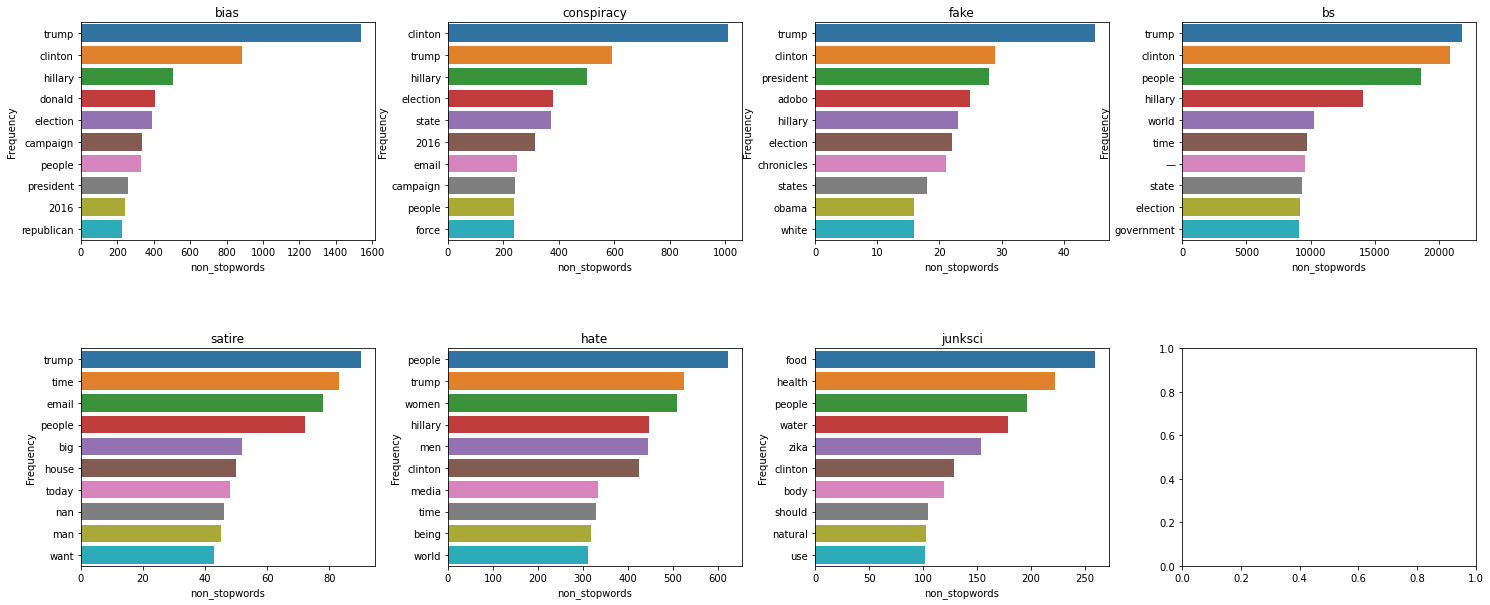

In [15]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    top = top_tokens[i].sort_values(by = 'count', ascending = False)[:10]
    grid = sns.barplot(x = top['count'], y = top['token'], ax = ax)
    grid.set(title = types[i], xlabel = 'non_stopwords', ylabel = 'Frequency')
    

<h3>Named Entity Recognition</h3>

In [16]:
def get_target_entities(s):
    people = []
    s = str(s)
    tokens = [word for sent in nltk.sent_tokenize(s) for word in nltk.word_tokenize(sent)]
    targets = ['PERSON', 'GPE', 'ORGANIZATION', 'FACILITY', 'NORP', 'ORG', 
               'LOC', 'EVENT', 'LAW']
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)

    for entity in entities.subtrees():
        if entity.label() == "PERSON":
            name = []
            for leaf in entity.leaves():
                name.append(leaf[0])
            people.append(" ".join(name))
    return people

In [17]:
df['entities'] = df['non_stopwords'].apply(get_target_entities)

<h4>NER On Title</h4>

In [18]:
df['title_entities'] = df['title_no_stopwords'].apply(get_target_entities)

<h2>Visualize Top Entities</h2>

<h4>Text</h4>

In [19]:
top = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('entities')
    exploded = exploded[pd.isnull(exploded['entities']) == False]
    exploded['entities'] = exploded['entities'].apply(lambda s: s[1:])
    top.append(exploded['entities'].value_counts())

In [20]:
fake = top[2]
top = top[:2] + top[3:]

Text(0.5, 0.98, 'Most Common Entities in Fake News Articles')

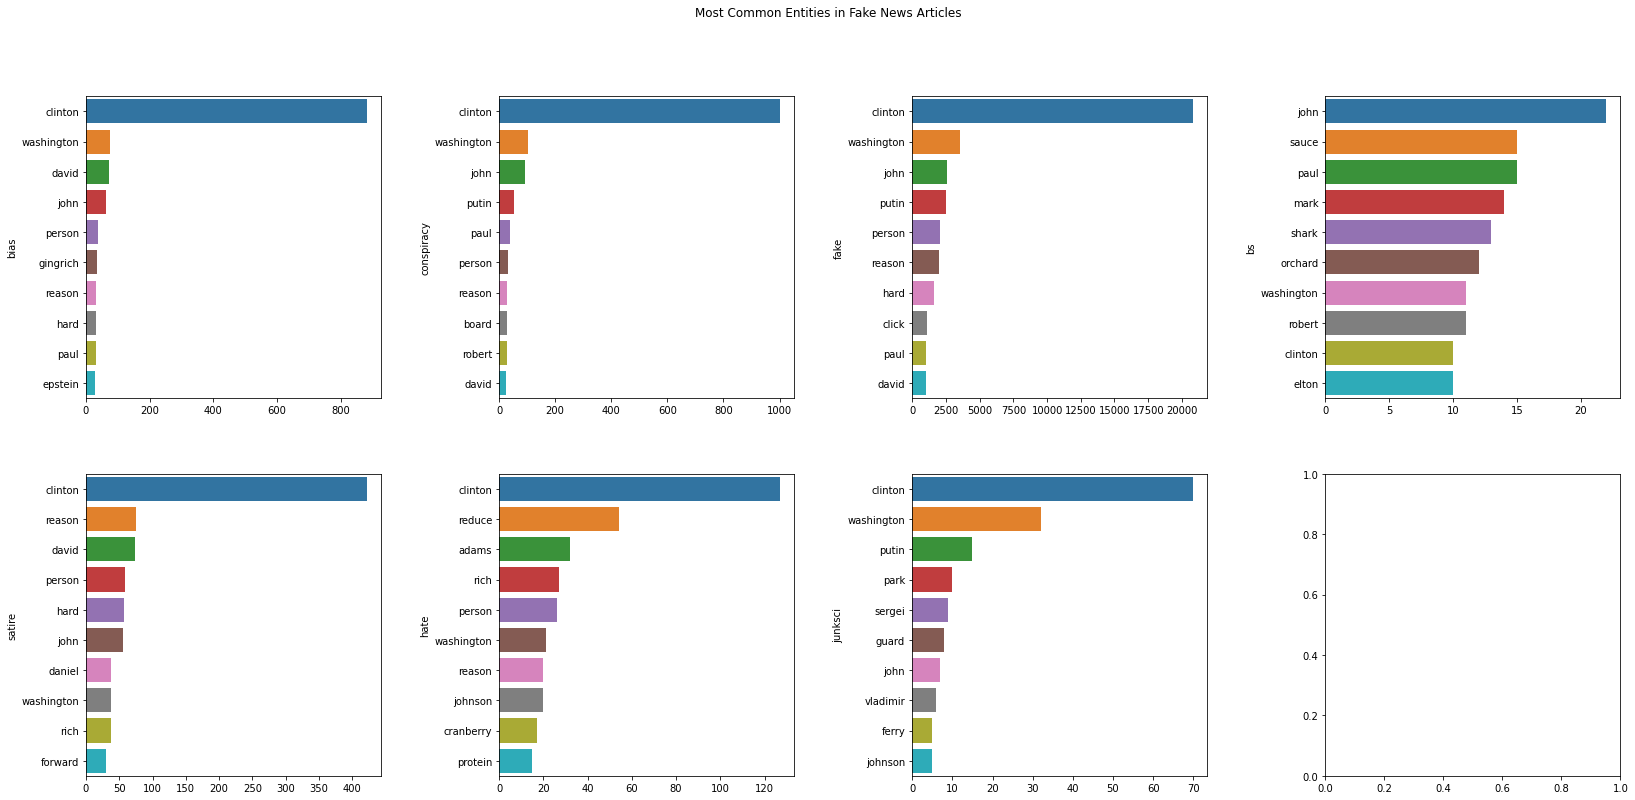

In [32]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(27.5, 12.5)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    top_subset = top[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = t)
    
fig.suptitle("Most Common Entities in Fake News Articles")

<h4>Title</h4>

In [22]:
top_ners = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('title_entities')
    exploded = exploded[pd.isnull(exploded['title_entities']) == False]
    exploded['title_entities'] = exploded['title_entities'].apply(lambda s: s[1:])
    top_ners.append(exploded['title_entities'].value_counts())

Text(0.5, 0.98, 'Most Common Entities in Titles of Fake News Articles')

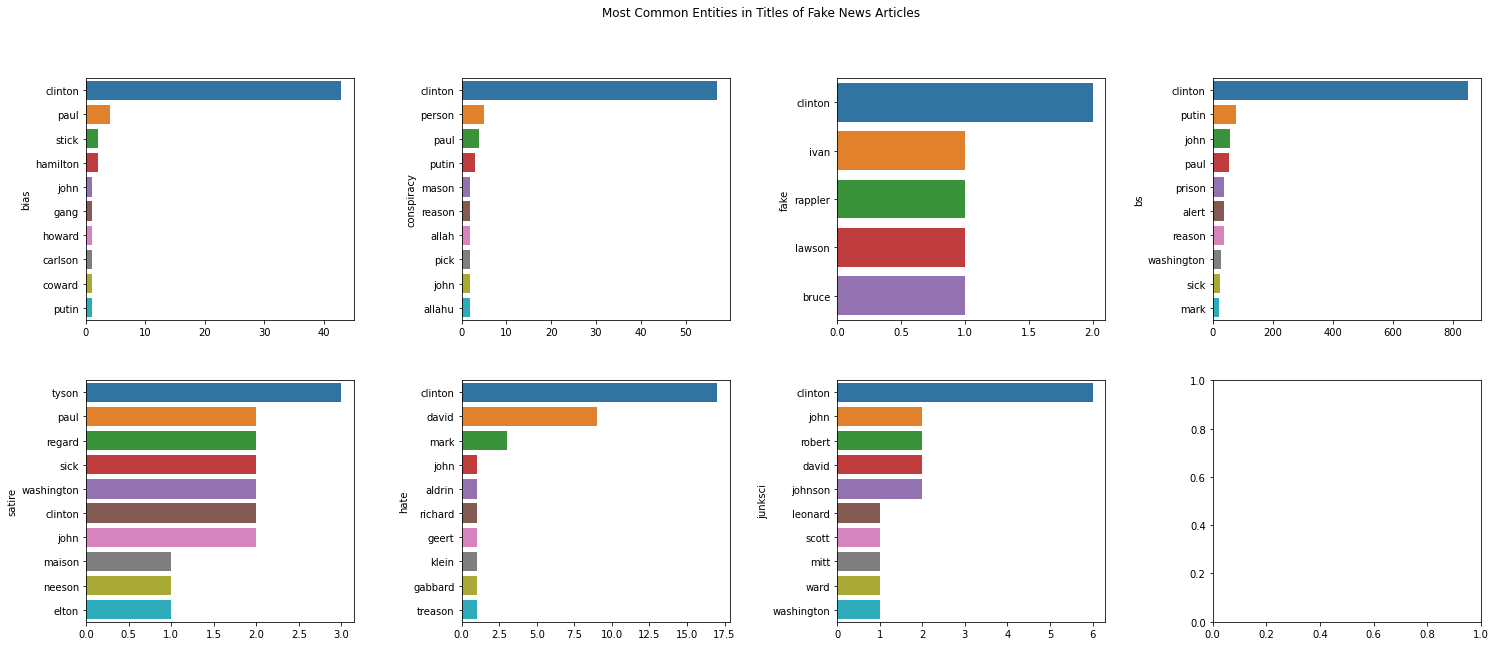

In [31]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    top_subset = top_ners[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = t)
    
fig.suptitle("Most Common Entities in Titles of Fake News Articles")